# Natural Language Processing Notebook

## Evaluation of Language Models on Answers Dataset (Regression)

### Data Preprocessing
- Loaded the answers dataset and performed preprocessing steps including text normalization, tokenization, and removal of stopwords.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
from sklearn.model_selection import GridSearchCV
import re
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [341]:
data = pd.read_csv('answers.csv')
data.head(5)

,id,answer,score,correct
0,1.1,High risk problems are address in the prototyp...,3.5,0.0
1,1.1,To simulate portions of the desired final prod...,5.0,1.0
2,1.1,A prototype program simulates the behaviors of...,4.0,1.0
3,1.1,Defined in the Specification phase a prototype...,5.0,1.0
4,1.1,It is used to let the users have a first idea ...,3.0,0.0


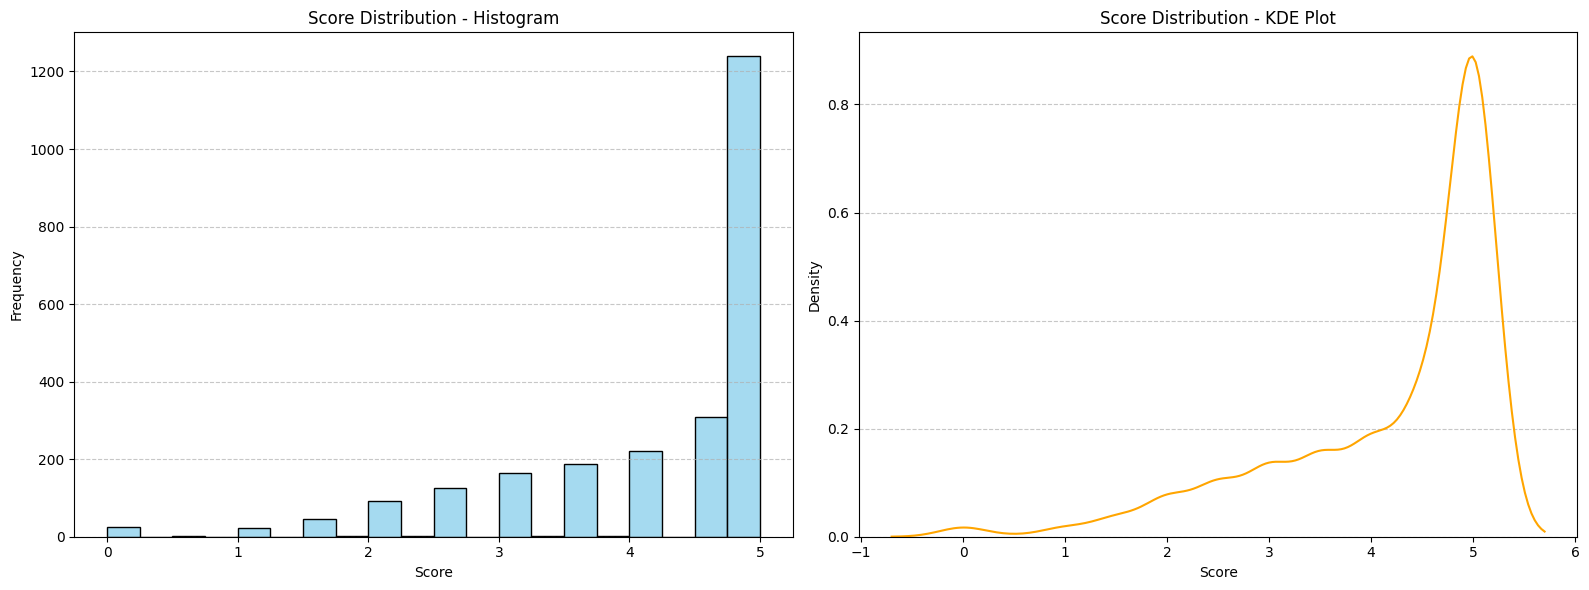

In [342]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data['score'], bins=20, kde=False, color='skyblue', ax=axs[0])
axs[0].set_title('Score Distribution - Histogram')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Frequency')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.kdeplot(data['score'], color='orange', ax=axs[1])
axs[1].set_title('Score Distribution - KDE Plot')
axs[1].set_xlabel('Score')
axs[1].set_ylabel('Density')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


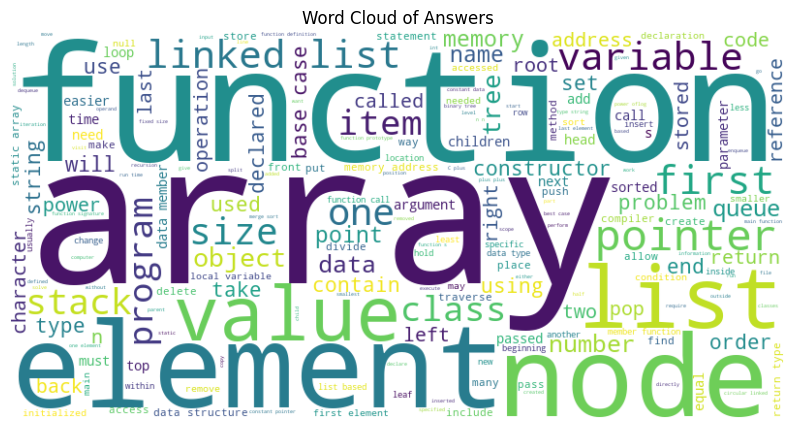

In [343]:
all_answers = ' '.join(data['answer'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_answers)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Answers')
plt.axis('off')
plt.show()

In [344]:
def preprocess_text(text):
    
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return lemmatized_tokens

In [345]:
def text_to_vec(text, model):
    vecs = []
    for word in text:
        if word in model.key_to_index:
            vecs.append(model[word])
    if len(vecs) > 0:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(model.vector_size)

In [346]:
data["answer"] = data["answer"].apply(preprocess_text)

In [347]:
data

,id,answer,score,correct
0,1.1,"[high, risk, problem, address, prototype, prog...",3.5,0.0
1,1.1,"[simulate, portion, desired, final, product, q...",5.0,1.0
2,1.1,"[prototype, program, simulates, behavior, port...",4.0,1.0
3,1.1,"[defined, specification, phase, prototype, sti...",5.0,1.0
4,1.1,"[used, let, user, first, idea, completed, prog...",3.0,0.0
...,...,...,...,...
2437,12.1,"[log, n]",5.0,1.0
2438,12.1,"[minus, 1, divided, 2]",1.5,0.0
2439,12.1,[2n1],2.5,0.0
2440,12.1,"[take, h, step, h, height, tree]",5.0,1.0


### Feature Extraction
- Utilized Bag-of-Words (BoW), TF-IDF vectorization, and Word2Vec word embeddings to represent text data in numerical form.

In [348]:
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(data['answer'].apply(lambda x: ' '.join(x)))
print(X_bow[0])

  (0, 976)	1
  (0, 1882)	1
  (0, 1656)	1
  (0, 104)	1
  (0, 1692)	2
  (0, 1668)	2
  (0, 1287)	1
  (0, 2140)	1
  (0, 833)	1
  (0, 1305)	1
  (0, 136)	1
  (0, 2283)	1
  (0, 1969)	1
  (0, 391)	1
  (0, 2017)	1
  (0, 1609)	1
  (0, 1673)	1


In [349]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['answer'].apply(lambda x: ' '.join(x)))
print(X_tfidf[0])

  (0, 1673)	0.2765129460793549
  (0, 1609)	0.2516291538993865
  (0, 2017)	0.21424124767532646
  (0, 391)	0.29106903138037477
  (0, 1969)	0.22674536171941803
  (0, 2283)	0.15209398517951273
  (0, 136)	0.16721543214247367
  (0, 1305)	0.18831681093444316
  (0, 833)	0.29106903138037477
  (0, 2140)	0.2460951871044503
  (0, 1287)	0.17850565575264057
  (0, 1668)	0.275576146361274
  (0, 1692)	0.34684088269120444
  (0, 104)	0.146881991157807
  (0, 1656)	0.16500552079983902
  (0, 1882)	0.29106903138037477
  (0, 976)	0.29106903138037477


In [2]:
model = KeyedVectors.load_word2vec_format(r'GoogleNews-vectors-negative300.bin', binary=True)

In [353]:
df = data.copy()
df['answer'] = [text_to_vec(text, model) for text in df['answer']]
vec_matrix = np.array([vec for vec in df['answer']])
df.drop(['answer'], axis=1, inplace=True)
final_df = df.join(pd.DataFrame(vec_matrix))
final_df.columns = final_df.columns.astype(str)

In [354]:
X = final_df.drop(['id', 'score', ], axis=1)
y = final_df['score']

In [355]:
X

,correct,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,0.0,-0.011314,0.009007,0.036163,0.094203,-0.086490,0.018722,0.106346,0.020463,0.070989,...,-0.109144,0.056168,-0.094267,-0.002266,-0.000630,0.034838,-0.050432,-0.082519,-0.058517,-0.084094
1,1.0,0.060389,0.015101,0.001943,0.078427,-0.051615,-0.006441,0.117803,-0.036965,0.066339,...,-0.111039,0.037476,-0.037692,0.014641,-0.033205,0.092497,-0.027912,-0.017063,-0.050849,-0.066237
2,1.0,-0.026572,0.003052,0.023926,0.027011,-0.124079,0.011813,0.080247,-0.029785,0.052379,...,-0.120128,0.113636,-0.021476,-0.043010,0.050251,0.023088,0.028648,-0.092174,-0.106146,0.061167
3,1.0,-0.008671,0.014805,0.000142,0.075033,-0.145578,0.044373,0.101935,-0.095030,0.071394,...,-0.168329,0.041958,-0.046039,-0.039089,-0.018669,0.049331,-0.036801,-0.036714,-0.032854,0.002749
4,0.0,-0.004554,-0.003926,0.033550,0.072991,-0.047009,0.024852,0.105057,-0.020392,0.127749,...,-0.134584,0.128961,-0.055376,0.009431,-0.027363,0.014968,0.045993,-0.082018,-0.065550,-0.084932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437,1.0,0.059906,-0.001709,-0.172974,0.051758,-0.112305,0.082764,0.064453,0.097168,-0.015137,...,0.093750,0.042542,0.026489,0.014893,-0.046875,-0.259277,0.060059,-0.158569,-0.154785,-0.022278
2438,0.0,0.057083,-0.097229,0.092163,0.070007,-0.083618,0.013002,-0.010864,-0.219482,0.080505,...,-0.066467,0.048859,-0.047043,0.087646,-0.072632,-0.008606,-0.140869,-0.116821,-0.064392,0.026764
2439,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2440,1.0,-0.039510,0.178182,-0.027710,-0.015666,-0.085327,-0.125814,0.041423,-0.071615,0.065877,...,-0.049072,0.149902,-0.137634,0.075846,-0.028071,-0.089600,-0.154867,-0.002360,-0.088175,0.027323


### Regression Models
- Trained Linear Regression, Decision Tree, and Support Vector Regression (SVR) models.
- Optimized hyperparameters using GridSearchCV.
- Evaluated model performance using MSE, RMSE, and MAE.
- Compared error metrics across different models.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

In [ ]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae}

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print("Linear Regression Evaluation:")
print(evaluate_model(y_test, lr_pred))

Linear Regression Evaluation:
{'MSE': 0.267010000486232, 'RMSE': 0.516730104102937, 'MAE': 0.3785642715280089}


In [ ]:
param_grid = {'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],'min_samples_split': [2, 5, 10, 20, 30],'min_samples_leaf': [1, 2, 4, 6, 8, 10]}
dt_model = DecisionTreeRegressor()
grid_search = GridSearchCV(dt_model, param_grid, cv = 10, scoring='neg_mean_squared_error', n_jobs = -1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
best_dt_model = DecisionTreeRegressor(**best_params)
best_dt_model.fit(X_train, y_train)
best_dt_pred = best_dt_model.predict(X_test)
print("Best Decision Tree Evaluation:")
print(evaluate_model(y_test, best_dt_pred))

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 30}
Best Decision Tree Evaluation:
{'MSE': 0.2921023861729965, 'RMSE': 0.5404649721980107, 'MAE': 0.36539123672201745}


In [ ]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'C': [0.1, 1, 10],'gamma': ['scale', 'auto'],'epsilon': [0.1, 0.2, 0.5]}
svr_model = SVR()
grid_search = GridSearchCV(svr_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train, y_train)
best_svr_pred = best_svr_model.predict(X_test)
print("Best Support Vector Regression (SVR) Evaluation:")
print(evaluate_model(y_test, best_svr_pred))

Best Parameters: {'C': 1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'poly'}
Best Support Vector Regression (SVR) Evaluation:
{'MSE': 0.2066250216324193, 'RMSE': 0.45456025082756557, 'MAE': 0.3378771237804957}


In [ ]:
mse_lr = mean_squared_error(y_test, lr_pred)
mse_best_dt = mean_squared_error(y_test, best_dt_pred)
mse_best_svr = mean_squared_error(y_test, best_svr_pred)

mae_lr = mean_absolute_error(y_test, lr_pred)
mae_best_dt = mean_absolute_error(y_test, best_dt_pred)
mae_best_svr = mean_absolute_error(y_test, best_svr_pred)

rmse_lr = root_mean_squared_error(y_test, lr_pred)
rmse_best_dt = root_mean_squared_error(y_test, best_dt_pred)
rmse_best_svr = root_mean_squared_error(y_test, best_svr_pred)

error_data = {
    'Model': ['Linear Regression', 'Decision Tree', 'SVM'],
    'MSE': [mse_lr, mse_best_dt, mse_best_svr],
    'RMSE': [rmse_lr, rmse_best_dt, rmse_best_svr],
    'MAE': [mae_lr, mae_best_dt, mae_best_svr]
}
error_df = pd.DataFrame(error_data)
print("Error metrics for each model:")
error_df


Error metrics for each model:


,Model,MSE,RMSE,MAE
0,Linear Regression,0.267010,0.516730,0.378564
1,Decision Tree,0.292102,0.540465,0.365391
2,SVM,0.206625,0.454560,0.337877


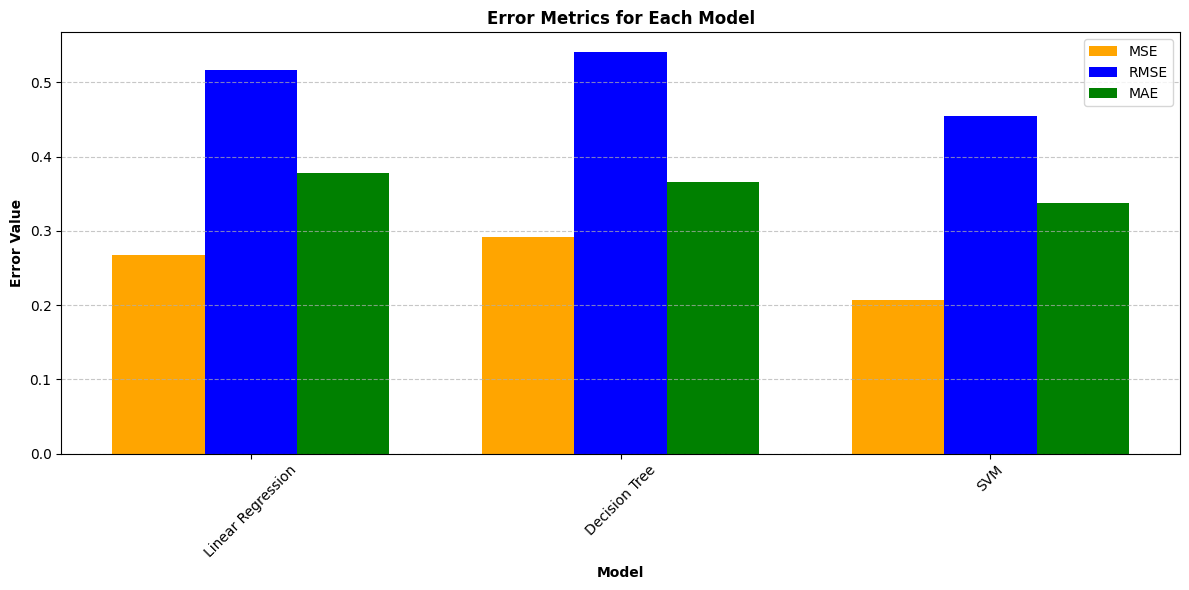

In [ ]:
models = ['Linear Regression', 'Decision Tree', 'SVM']
mse_values = [mse_lr, mse_best_dt, mse_best_svr]
rmse_values = [rmse_lr, rmse_best_dt, rmse_best_svr]
mae_values = [mae_lr, mae_best_dt, mae_best_svr]

bar_width = 0.25

r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(12, 6))
plt.bar(r1, mse_values, color='orange', width=bar_width, label='MSE')
plt.bar(r2, rmse_values, color='blue', width=bar_width, label='RMSE')
plt.bar(r3, mae_values, color='green', width=bar_width, label='MAE')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models, rotation=45)

plt.ylabel('Error Value', fontweight='bold')
plt.title('Error Metrics for Each Model', fontweight='bold')
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Error Metrics Comparison

The table below displays the error metrics for each language model evaluated on the answers dataset:

| Model              | MSE       | RMSE      | MAE       |
|--------------------|-----------|-----------|-----------|
| Linear Regression  | 0.267010  | 0.516730  | 0.378564  |
| Decision Tree      | 0.292102  | 0.540465  | 0.365391  |
| SVM                | 0.206625  | 0.454560  | 0.337877  |

### Interpretation:

- **Linear Regression**: Achieves moderate performance with slightly higher MAE compared to other models.
- **Decision Tree**: Shows slightly higher error metrics compared to Linear Regression and SVM.
- **SVM (Support Vector Machine)**: Outperforms other models with the lowest error metrics, indicating better predictive performance.

Based on the error metrics, the SVM model appears to be the best choice for predicting answer scores in this dataset.


## Evaluation of Language Models on Tweets Dataset (Classification)

### Data Preprocessing
- Preprocessed Twitter dataset by removing HTML tags, URLs, punctuation, and emojis.
- Applied tokenization and stopwords removal.

In [54]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

In [64]:
train_data = pd.read_csv('twitter_validation.csv', names=['Tweet ID', 'Entity', 'Sentiment', 'Tweet content'])
validation_data = pd.read_csv('twitter_training.csv', names=['Tweet ID', 'Entity', 'Sentiment', 'Tweet content'])
data = pd.concat([train_data, validation_data], ignore_index = False)
data.head()

,Tweet ID,Entity,Sentiment,Tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


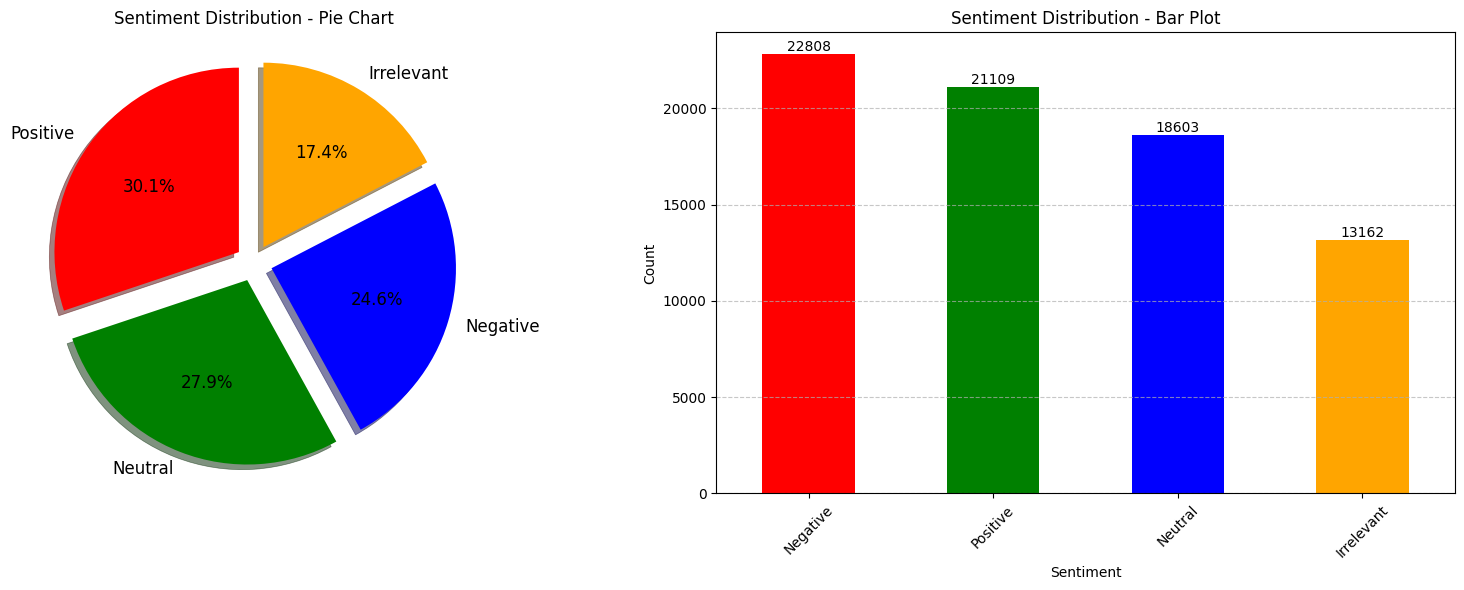

In [4]:
colors = ['red', 'green', 'blue', 'orange']
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].pie(data['Sentiment'].value_counts(), labels = data['Sentiment'].unique(), autopct='%1.1f%%',
            startangle=90, wedgeprops={'linewidth': 0.5}, textprops={'fontsize': 12},
            explode=[0.1, 0.1, 0.1, 0.1], colors=colors, shadow=True)
axs[0].set_title('Sentiment Distribution - Pie Chart')

axs[1] = data['Sentiment'].value_counts().plot(kind = 'bar', color = colors, ax = axs[1])
axs[1].set_title('Sentiment Distribution - Bar Plot')
axs[1].set_xlabel('Sentiment')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

for p in axs[1].patches:
    axs[1].annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

In [65]:
data.dropna(inplace = True)
data.isnull().sum()   

Tweet ID         0
Entity           0
Sentiment        0
Tweet content    0
dtype: int64

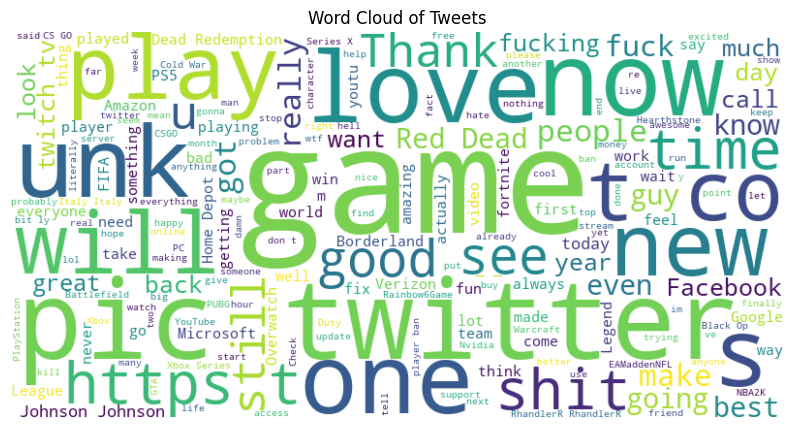

In [6]:
all_tweets = ' '.join(data['Tweet content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Tweets')
plt.axis('off')
plt.show()

In [66]:
remove_duplicates = data.drop_duplicates()
data = remove_duplicates
data.duplicated().sum()

0

In [67]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def filter_non_string(df, column):
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    return df

def normalize_text(text):
    return text.lower()

def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def tokenize_text(text):
    return word_tokenize(text)

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def remove_emojis(tokens):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002500-\U00002BEF"
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return [emoji_pattern.sub(r'', token) for token in tokens]

def preprocess_text(df):
    df = filter_non_string(df, 'Tweet content')
    df['Tweet content'] = df['Tweet content'].apply(normalize_text)
    df['Tweet content'] = df['Tweet content'].apply(remove_html_tags)
    df['Tweet content'] = df['Tweet content'].apply(remove_urls)
    df['Tweet content'] = df['Tweet content'].apply(remove_numbers)
    df['Tweet content'] = df['Tweet content'].apply(remove_punctuation)
    df['Tweet content'] = df['Tweet content'].apply(tokenize_text)
    df['Tweet content'] = df['Tweet content'].apply(remove_stopwords)
    df['Tweet content'] = df['Tweet content'].apply(remove_emojis)
    return df


In [68]:
data = preprocess_text(data)

In [69]:
data.head()

,Tweet ID,Entity,Sentiment,Tweet content
0,3364,Facebook,Irrelevant,"[mentioned, facebook, struggling, motivation, ..."
1,352,Amazon,Neutral,"[bbc, news, amazon, boss, jeff, bezos, rejects..."
2,8312,Microsoft,Negative,"[microsoft, pay, word, functions, poorly, sams..."
3,4371,CS-GO,Negative,"[csgo, matchmaking, full, closet, hacking, tru..."
4,4433,Google,Neutral,"[president, slapping, americans, face, really,..."


### Feature Extraction
- Utilized TF-IDF vectorization, Bag-of-Words (BoW), and Word2Vec word embeddings for feature representation.

In [70]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(data['Tweet content'].apply(lambda x: ' '.join(x)))
print(tfidf_vectors[0])

  (0, 22919)	0.19312295442867025
  (0, 31435)	0.19052022725598677
  (0, 17490)	0.23787184233841957
  (0, 31854)	0.23744143933546916
  (0, 13044)	0.27345526696819955
  (0, 32305)	0.19888905150345076
  (0, 2667)	0.23498149282828204
  (0, 12408)	0.1194974438112275
  (0, 13743)	0.3109285300269272
  (0, 2036)	0.2988000579700611
  (0, 13092)	0.13527884994328399
  (0, 32312)	0.23498149282828204
  (0, 32572)	0.27977604867457695
  (0, 7383)	0.14548998257046994
  (0, 27481)	0.18583298596865558
  (0, 12751)	0.1382903399830703
  (0, 20076)	0.2780662980420079
  (0, 30415)	0.24633297333962306
  (0, 10346)	0.13944613973583936
  (0, 19251)	0.24411621916895923


In [71]:
bow_vectorizer = CountVectorizer()
bow_vectors = bow_vectorizer.fit_transform(data['Tweet content'].apply(lambda x: ' '.join(x)))
print(bow_vectors[0])

  (0, 19251)	1
  (0, 10346)	1
  (0, 30415)	1
  (0, 20076)	1
  (0, 12751)	1
  (0, 27481)	1
  (0, 7383)	1
  (0, 32572)	1
  (0, 32312)	1
  (0, 13092)	1
  (0, 2036)	1
  (0, 13743)	1
  (0, 12408)	1
  (0, 2667)	1
  (0, 32305)	1
  (0, 13044)	1
  (0, 31854)	1
  (0, 17490)	1
  (0, 31435)	1
  (0, 22919)	1


In [37]:
def text_to_vec(text, model):
    vecs = []
    for word in text:
        if word in model.key_to_index:
            vecs.append(model[word])
    if vecs:  
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(model.vector_size)

In [74]:
df = data.copy()
df['Tweet content'] = df['Tweet content'].apply(lambda x: text_to_vec(x, model))
vec_matrix = np.array(df['Tweet content'].tolist())
df.drop(['Tweet content'], axis=1, inplace=True)
final_df = df.join(pd.DataFrame(vec_matrix))
final_df.columns = final_df.columns.astype(str)

In [75]:
final_df.dropna(inplace = True)
final_df

,Tweet ID,Entity,Sentiment,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,3364,Facebook,Irrelevant,0.057376,0.024659,-0.001575,0.099040,-0.033658,0.024084,0.073360,...,-0.023581,0.088409,-0.142572,-0.010318,-0.078226,-0.053967,0.015200,-0.097760,0.053845,0.012573
1,352,Amazon,Neutral,-0.072342,0.089193,-0.045134,0.015656,0.042623,0.000547,0.001770,...,0.014508,0.090210,-0.129196,0.118388,-0.006714,-0.002660,0.012370,0.017324,-0.017075,-0.018372
2,8312,Microsoft,Negative,0.174707,-0.069336,-0.049500,0.074097,-0.149609,-0.004248,-0.007837,...,-0.065308,0.040900,-0.042285,0.079883,0.073730,-0.026758,-0.126769,-0.047607,-0.004364,0.003760
3,4371,CS-GO,Negative,0.051392,0.015738,-0.069772,0.047376,0.020717,0.161063,-0.003278,...,-0.015817,0.065011,-0.102260,0.023420,-0.020647,-0.083670,0.141854,-0.006880,-0.092913,0.105399
4,4433,Google,Neutral,0.029436,0.005715,0.073375,0.055065,-0.160134,-0.047710,0.026259,...,0.006429,0.111728,-0.089543,0.001630,-0.119207,-0.057933,0.034879,-0.069070,0.094333,0.022261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72134,11157,TomClancysGhostRecon,Positive,-0.021451,-0.026622,0.024010,0.088419,-0.080378,0.054049,0.122599,...,-0.124221,0.137362,-0.010010,-0.016572,-0.008007,-0.039773,-0.026434,-0.049577,-0.035356,0.014686
72135,11157,TomClancysGhostRecon,Positive,-0.043616,-0.028772,0.017480,0.079243,-0.083948,0.031598,0.112398,...,-0.119128,0.143604,-0.002246,-0.022258,-0.026947,-0.045508,-0.058032,-0.060004,-0.041138,-0.004883
72136,11157,TomClancysGhostRecon,Positive,-0.033948,-0.043054,0.026709,0.079097,-0.088391,0.048761,0.115132,...,-0.136511,0.146826,-0.007251,-0.023185,-0.003632,-0.039404,-0.041040,-0.058929,-0.024341,0.009026
72137,11157,TomClancysGhostRecon,Positive,-0.004857,-0.026446,0.042809,0.117463,-0.091195,0.040506,0.096171,...,-0.135339,0.133545,-0.052543,0.012335,-0.039982,-0.065186,-0.046099,-0.030112,-0.040135,-0.019484


### Classification Models
- Trained Logistic Regression, Support Vector Machine (SVM), Decision Tree, and Random Forest models.
- Optimized hyperparameters using GridSearchCV.
- Evaluated model performance using accuracy, F1 score, precision, and recall.
- Compared model performance across different metrics.

In [40]:
X = final_df.drop(['Tweet ID', 'Sentiment', 'Entity'], axis = 1)
y = final_df['Sentiment']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [53]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_metrics = {'Accuracy': accuracy_score(y_test, lr_pred),'F1 Score': f1_score(y_test, lr_pred, average='weighted'),'Precision': precision_score(y_test, lr_pred, average='weighted'),'Recall': recall_score(y_test, lr_pred, average='weighted')}

In [52]:
param_grid_svm = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'C': [0.1, 1, 10],'gamma': ['scale', 'auto']}
svm_model = SVC()
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)
best_params_svm = grid_search_svm.best_params_
best_svm_model = SVC(**best_params_svm)
best_svm_model.fit(X_train, y_train)
best_svm_pred = best_svm_model.predict(X_test)
svm_metrics = {'Accuracy': accuracy_score(y_test, best_svm_pred),'F1 Score': f1_score(y_test, best_svm_pred, average='weighted'),'Precision': precision_score(y_test, best_svm_pred, average='weighted'),'Recall': recall_score(y_test, best_svm_pred, average='weighted')}

In [51]:
param_grid_dt = {'max_depth': [None, 10, 20, 30, 40, 50],'min_samples_split': [2, 5, 10, 20, 30],'min_samples_leaf': [1, 2, 4, 6, 8, 10]}
dt_model = DecisionTreeClassifier()
grid_search_dt = GridSearchCV(dt_model, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)
best_params_dt = grid_search_dt.best_params_
best_dt_model = DecisionTreeClassifier(**best_params_dt)
best_dt_model.fit(X_train, y_train)
best_dt_pred = best_dt_model.predict(X_test)
dt_metrics = {'Accuracy': accuracy_score(y_test, best_dt_pred),'F1 Score': f1_score(y_test, best_dt_pred, average='weighted'),'Precision': precision_score(y_test, best_dt_pred, average='weighted'),'Recall': recall_score(y_test, best_dt_pred, average='weighted')}

In [55]:
param_grid_rf = {'n_estimators': [50, 100, 200],'max_depth': [None, 10, 20, 30],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}
rf_model = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
best_rf_model = RandomForestClassifier(**best_params_rf)
best_rf_model.fit(X_train, y_train)
best_rf_pred = best_rf_model.predict(X_test)
rf_metrics = {'Accuracy': accuracy_score(y_test, best_rf_pred),'F1 Score': f1_score(y_test, best_rf_pred, average='weighted'),'Precision': precision_score(y_test, best_rf_pred, average='weighted'),'Recall': recall_score(y_test, best_rf_pred, average='weighted')}

In [56]:
model_names = ['Decision Tree', 'SVM', 'Logistic Regression', 'Random Forest']
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
metrics_table = pd.DataFrame([dt_metrics, svm_metrics, lr_metrics, rf_metrics],index=model_names,columns=metrics)
metrics_table

,Accuracy,F1 Score,Precision,Recall
Decision Tree,0.8675,0.867403,0.867569,0.8675
SVM,0.8550,0.854903,0.854888,0.8550
Logistic Regression,0.5650,0.559138,0.574923,0.5650
Random Forest,0.8600,0.859795,0.868385,0.8600


In [57]:
models = ['Decision Tree', 'SVM', 'Logistic Regression', 'Random Forest']
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
metrics_values = [[dt_metrics[metric] for metric in metrics],[svm_metrics[metric] for metric in metrics],[lr_metrics[metric] for metric in metrics],[rf_metrics[metric] for metric in metrics]]

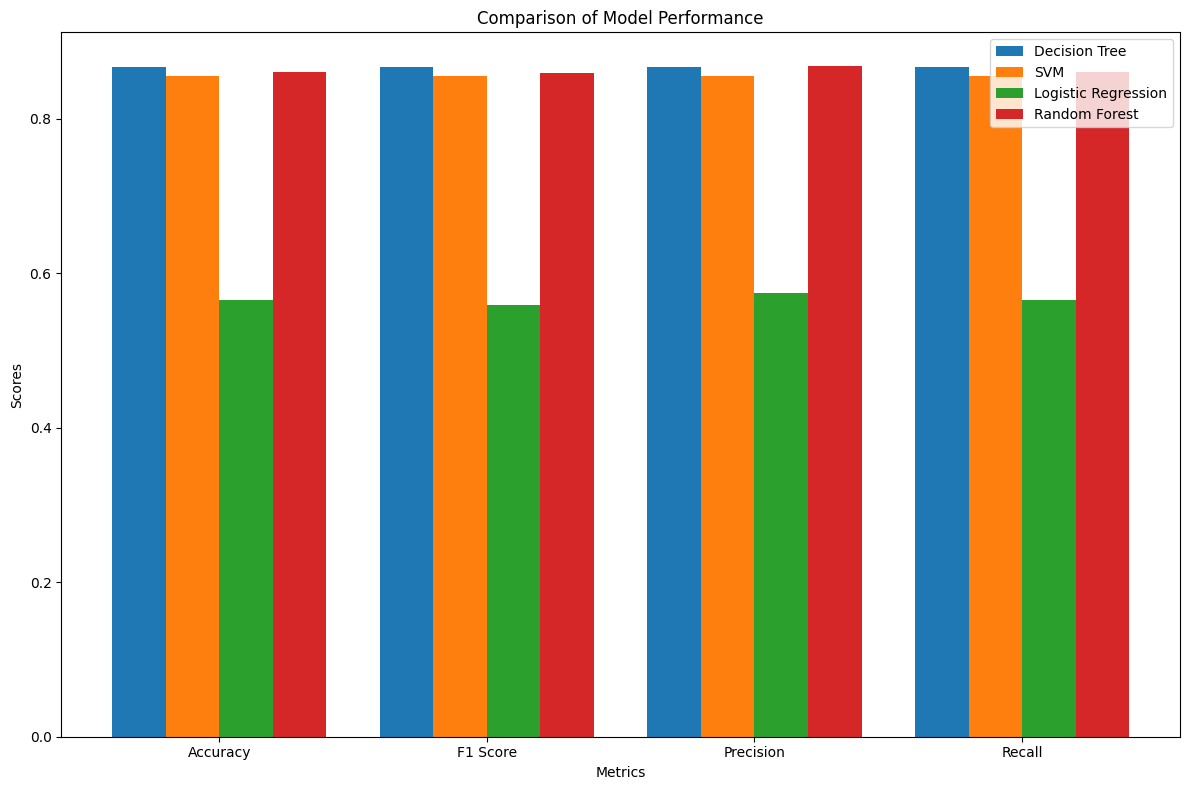

In [58]:
x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - 1.5*width, metrics_values[0], width, label='Decision Tree')
rects2 = ax.bar(x - 0.5*width, metrics_values[1], width, label='SVM')
rects3 = ax.bar(x + 0.5*width, metrics_values[2], width, label='Logistic Regression')
rects4 = ax.bar(x + 1.5*width, metrics_values[3], width, label='Random Forest')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()
plt.show()

### Performance Metrics Comparison

The table below summarizes the performance metrics for each language model evaluated on the tweets dataset:

| Model                | Accuracy  | F1 Score  | Precision | Recall    |
|----------------------|-----------|-----------|-----------|-----------|
| Decision Tree        | 0.8675    | 0.867403  | 0.867569  | 0.8675    |
| SVM                  | 0.8550    | 0.854903  | 0.854888  | 0.8550    |
| Logistic Regression  | 0.5650    | 0.559138  | 0.574923  | 0.5650    |
| Random Forest        | 0.8600    | 0.859795  | 0.868385  | 0.8600    |

### Interpretation:

- **Decision Tree**: Shows the highest accuracy and balanced performance in terms of F1 Score, Precision, and Recall.
- **SVM (Support Vector Machine)**: Performs slightly lower than Decision Tree but maintains a competitive performance across all metrics.
- **Logistic Regression**: Exhibits the lowest accuracy and F1 Score among the evaluated models, suggesting weaker predictive power.
- **Random Forest**: Demonstrates similar performance to Decision Tree, with slightly lower accuracy.

Considering the overall performance across multiple metrics, the Decision Tree model emerges as the best option for sentiment analysis on tweets. It achieves a good balance between accuracy, precision, and recall.